# Creating an optimal Molecule's Potential Energy Curve using Adapt-VQE

A potential energy curve gives the ground energy of an assemble of atoms as function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefor, such curve can be powerful tool in computational chemistry, for predicting molecular structure and spectrum.

In this tutorial, we will demonstrate how, using Classiq's VQE package, the user can create a Molecule's potential energy curve, and compare the result those of the Hartree-Fock approximative method and to the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## Main Idea
The main idea is to use the __qpe_for_molecules.ipynb__ notebook, but replace __qpe_flexible__ with __my_qpe_flexible__. Then, create an iterator function that uses this approach to find eigenvalues as part of an adapt-VQE implementation.

In [1]:
#import time
import matplotlib.pyplot as plt
import numpy as np
import itertools, warnings
from tqdm import tqdm
from datetime import datetime
from classiq import *
from classiq.applications.chemistry import (
    ChemistryExecutionParameters,
    FermionicOperator,
    HamiltonianProblem,
    HEAParameters,
    Molecule,
    MoleculeProblem,
    UCCParameters,
    SummedFermionicOperator,
)
from classiq.execution import OptimizerType
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import pauli_operator_to_hamiltonian
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi
import numpy as np
import math,cmath
from scipy.constants import h, e
from scipy.optimize import minimize
import itertools

#from classiq import construct_chemistry_model, execute, synthesize


## 0. Definitions
### Molecules
We start this defining some examples of molecular pairs and triplets.

In [ ]:
num1, start1, stop1 = 3, 0.20, 1   #First Linear Space 
num2, start2, stop2 = 3, 1.4, 3.5  #Second Linear Space
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2)) # prepare x,y vectors
molecules_LiH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, x))]) for x in distance]
molecules_FH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("F", (0.0, 0.0, x))]) for x in distance]
molecules_H2 = [Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, x))]) for x in distance]
molecules_O2 = [Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, x))]) for x in distance]
molecules_H2O = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y) in itertools.product(distance,distance)]
molecules_H3 = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_O3 = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("O", (0, x, y)), ("O", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_BeH2 = [Molecule(atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, x)), ("H", (0, 0, -x))]) for x in distance]

### Fermionic operators

Generate simple and double excitations from a reference state of Hartree-Fock.

The excitations are defined as:

\begin{equation}
\hat{T}_1 = \sum_{\substack{r \in \mathrm{occ} \\ p \in \mathrm{unocc}}} \hat{c}_p^\dagger \hat{c}_r
\end{equation}

where $\hat{c}_p^\dagger$ is the creation operator for an electron in orbital $p$ (unoccupied) and $\hat{c}_r$ is the annihilation operator for an electron in orbital $r$ (occupied).

\begin{equation}
\hat{T}_2 = \sum_{\substack{r,s \in \mathrm{occ} \\ r > s}} \sum_{\substack{p,q \in \mathrm{unocc} \\ p > q}} \hat{c}_p^\dagger \hat{c}_q^\dagger \hat{c}_r \hat{c}_s
\end{equation}

In this expression, the double summation runs over pairs of occupied orbitals $(r, s)$ and unoccupied ones $(p, q)$ with the ordering conditions $r > s$ and $p > q$ to avoid counting redundancies.

These expressions form the basis for constructing the excitation operator in methods such as the Unitary Coupled Cluster (UCC) to approximate the electronic wavefunction.

In [3]:
def excitations(electrons, orbitals, delta_sz=0, fermionic=False):
    r"""
    Args:
        electrons (int): Number of electrons (occupied orbitals).
        orbitals (int): Total number of spin‑orbitals (active space).
        delta_sz (int): Rule for the difference in spin projection (allowed: 0, ±1, ±2).
        fermionic (bool): If True, returns a fermionic representation (dictionaries) of each excitation; otherwise returns lists of indices.
    Returns:
        tuple(list, list): (singles, doubles) excitations.    
    Example:    
        >>> singles, doubles = excitations(2, 4)
        >>> print(singles)
        [[0, 2], [1, 3]]
        >>> print(doubles)
        [[0, 1, 2, 3]]
    """
    if electrons <= 0:raise ValueError(f"Number of electrons must be greater than 0, but got: {electrons}")
    if orbitals <= electrons: raise ValueError(f"Number of active spin-orbitals ({orbitals}) must be greater than the number of electrons ({electrons}).")
    if delta_sz not in (0, 1, -1, 2, -2): raise ValueError(f"Expected delta_sz values 0, ±1, or ±2 but got: {delta_sz}")
    sz = np.array([0.5 if (i % 2 == 0) else -0.5 for i in range(orbitals)])
    singles = [[r, p]
               for r in range(electrons)
               for p in range(electrons, orbitals)
               if np.isclose(sz[p] - sz[r], delta_sz)]
    doubles = [[s, r, q, p]
               for s in range(electrons - 1)
               for r in range(s+1, electrons)
               for q in range(electrons, orbitals - 1)
               for p in range(q+1, orbitals)
               if np.isclose(sz[p] + sz[q] - sz[r] - sz[s], delta_sz)]    
    if fermionic:
        fermionic_singles = [{"occupied": x[0], "unoccupied": x[1]} for x in singles]
        fermionic_doubles = [{"occupied": [x[0], x[1]], "unoccupied": [x[2], x[3]]} for x in doubles]
        return fermionic_singles, fermionic_doubles
    else:
        return singles, doubles
    

## 1. Auxiliary Operators

In [4]:
def create_problem(molecule, mapping="jordan_wigner", basis=None):
    def validate_molecule(mol):
        if not isinstance(mol, Molecule):
            raise TypeError("The object 'mol' must be of type Molecule")
        if not mol.atoms or len(mol.atoms) < 2:
            raise ValueError("The molecule must have at least 2 atoms.")
    try:
        validate_molecule(molecule)
        if basis is None:
            return MoleculeProblem(molecule=molecule, mapping=mapping, z2_symmetries=True, freeze_core=True)
        else:
            return MoleculeProblem(molecule=molecule, basis=basis, mapping=mapping, z2_symmetries=True, freeze_core=True)
    except Exception as e:
        raise RuntimeError("Error in create_problem: " + str(e))

def molecule_to_problem(molecule, mapp):
    problem = MoleculeProblem(molecule=molecule,mapping=mapp)
    operator= problem.generate_hamiltonian()
    return problem, operator.to_matrix(), int(np.log2(operator.to_matrix().shape[0]))

## 2. Vanilla VQE
This part would imitate the model of VQE already implemented on Classiq

In [5]:
def VanillaVQE(molecule,max_iter):
    chem_problem, mat, N = molecule_to_problem(molecule,'bravyi_kitaev')
    qmod = construct_chemistry_model(
        chemistry_problem=chem_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=max_iter,initial_point=None))
    qprog = synthesize(qmod)
    result = execute(qprog).result()
    chemistry_result_dict = result[1].value
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    return chemistry_result_dict["total_energy"], chemistry_result_dict["hartree_fock_energy"], result_exact  

In [6]:
energies_results=np.array([VanillaVQE(molecules_H2[k],10) for k in range(len(distance))])
VQE_energy=energies_results[:,0]
HF_energy=energies_results[:,1]
exact_energy=energies_results[:,2]    

This graph presents the ground state for $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. One can see that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within VQE scope.
One can similarly create graphs for different molecules (even n- dimensional or larger atom assemblies), to explore more curves.
## 3. Define Adapt_VQE using Flexible QPE

In [7]:
def fl_VQE(molecule,max_iter):
    chem_problem, mat, N = molecule_to_problem(molecule,'bravyi_kitaev')
    qmod = construct_chemistry_model(
        chemistry_problem=chem_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=max_iter,initial_point=None))
    preferences = Preferences(optimization_level=3)
    qprog = synthesize(qmod, preferences=preferences)
    result = execute(qprog).result()
    chemistry_result_dict = result[1].value
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    return chemistry_result_dict["total_energy"]

fVQE_energy=np.array([fl_VQE(molecules_H2[k],40) for k in range(len(distance))])


## 4. Implementation of Adapt VQE

In [8]:
pool1q=[]
ops1q= ["rx", "ry", "rz"]
pool2q=[]
ops2q= ["rxx", "ryy", "rzz"]

epsilon = 0.1

In [9]:
def ad_VQE(molecule,max_iter=10):
    qmods=[]
    chem_problem, mat, N = molecule_to_problem(molecule,'bravyi_kitaev')
    chem_ham= chem_problem.generate_hamiltonian()
    t2_list = [x for x in  itertools.combinations([x-1 for x in range(1,N+1)],2)]
    ansatz_ops = []
    params = []
    energy_trace = []
    grad_trace = []
    ansatz_1q_labels, ansatz_2q_labels = [],[]
    constraints = []
    a=True 
    for k in range(3):
    #while==True:                                                                 #Repite siempre, hasta que se diga lo contrario   
        gradients = []                                                           #Inicialización de arreglo de cálculo de gradientes
        for A in ['rx']:                                                           #Para cada operador en el pool
            ansatz_1q_labels.append(A)                          #Guardar la etiqueta del operador que produce el máximo
            ansatz_parameters = HEAParameters(reps=4,num_qubits=N,connectivity_map=t2_list,
            one_qubit_gates=ansatz_1q_labels, two_qubit_gates=ansatz_2q_labels,)
            execution_params = ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=max_iter,)
            model = construct_chemistry_model(chemistry_problem=chem_problem,use_hartree_fock=True,
            ansatz_parameters=ansatz_parameters,execution_parameters=execution_params,)
            qprog = synthesize(model)
        gradients=[]
        for A in ['crx']:                                                        #Para cada operador en el pool
            ansatz_2q_labels.append(A)                          #Guardar la etiqueta del operador que produce el máximo
            ansatz_parameters = HEAParameters(reps=4,num_qubits=N,connectivity_map=t2_list,
            one_qubit_gates=ansatz_1q_labels, two_qubit_gates=ansatz_2q_labels,)
            execution_params = ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=max_iter,)
            model = construct_chemistry_model(chemistry_problem=chem_problem,use_hartree_fock=False,
            ansatz_parameters=ansatz_parameters,execution_parameters=execution_params,)
            qprog = synthesize(model)
    ansatz_parameters = HEAParameters(reps=1,num_qubits=N,connectivity_map=t2_list,
                        one_qubit_gates=ansatz_1q_labels, two_qubit_gates=ansatz_2q_labels,)
    execution_params = ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=max_iter,)
    model = construct_chemistry_model(chemistry_problem=chem_problem,use_hartree_fock=True,
            ansatz_parameters=ansatz_parameters,execution_parameters=execution_params,)
    qprog = synthesize(model)
    write_qmod(model, "adapt_vqe_energy_curve") # save the last model to a qmod file
    result = execute(qprog).result()
    chemistry_result_dict = result[1].value
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    current_energy=chemistry_result_dict["total_energy"]
    return current_energy

aVQE_energy=np.array([ad_VQE(molecules_H2[k],10) for k in range(len(distance))])

## 5 Plot and comparing result

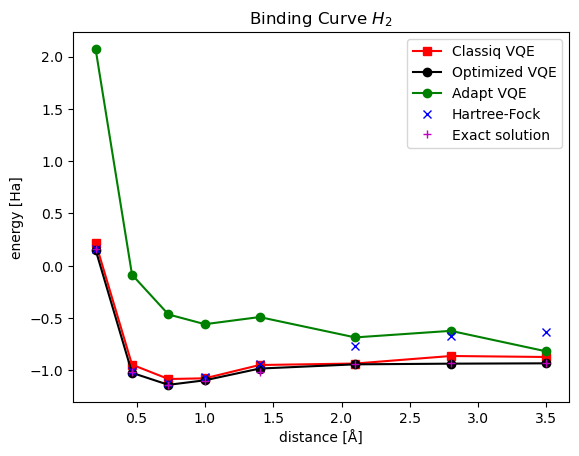

In [10]:
plt.plot(distance, VQE_energy, "r-s")
plt.plot(distance, fVQE_energy, "k-o")
plt.plot(distance, aVQE_energy, "g-o")
plt.plot(distance, HF_energy, "bx")
plt.plot(distance, exact_energy, "m+")
plt.xlabel(r"distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Optimized VQE", "Adapt VQE", "Hartree-Fock", "Exact solution"])
plt.title(r"Binding Curve $H_{2}$")
plt.show()

## 